In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import torch
import torch.nn as nn
import pandas as pd
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
ds_path = "/content/gdrive/MyDrive/Datasets/Cure The Princess"
train_df = pd.read_csv(ds_path+"/cure_the_princess_train.csv")
val_df = pd.read_csv(ds_path+"/cure_the_princess_validation.csv")
test_df = pd.read_csv(ds_path+"/cure_the_princess_test.csv")

In [4]:
train_df.head

<bound method NDFrame.head of       Phoenix Feather  Unicorn Horn  Dragon's Blood  Mermaid Tears  \
0                18.8           1.5            19.7            1.1   
1                 6.0           3.8            12.4           16.9   
2                22.4           7.9            28.6           11.2   
3                10.8           4.6             5.1           16.7   
4                 3.7           5.7             9.0            3.3   
...               ...           ...             ...            ...   
1247             35.6           8.7             8.0           18.3   
1248             23.1           2.5            26.3            4.5   
1249             22.4          19.6             7.4           10.8   
1250             22.5          12.5            24.5           14.2   
1251             12.3          17.6            13.0           11.0   

      Fairy Dust  Goblin Toes  Witch's Brew  Griffin Claw  Troll Hair  \
0           19.5         30.1          16.5           9.

In [5]:
X_train = train_df.drop('Cured', axis=1).values
y_train = train_df['Cured'].values

X_val = val_df.drop('Cured', axis=1).values
y_val = val_df['Cured'].values

X_test = test_df.drop('Cured', axis=1).values
y_test = test_df['Cured'].values

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [55]:

class MLP(nn.Module):
    def __init__(self, alpha=1e-3, l1=0, l2=0):
        super(MLP, self).__init__()
        self.hidden_layer_1 = nn.Linear(13, 100) 
        self.relu1 = nn.ReLU()

        self.hidden_layer_2 = nn.Linear(100, 50)
        self.relu2 = nn.ReLU()

        self.output_layer = nn.Linear(50, 1) 
        self.sigmoid = nn.Sigmoid()
        self.alpha = alpha  
        #self.l1 = l1
        self.l2 = l2

    def forward(self, x):
        out = self.hidden_layer_1(x)
        out = self.relu1(out)
    
        out = self.hidden_layer_2(out)
        out = self.relu2(out)
  
        out = self.output_layer(out)
        out = self.sigmoid(out)
        return out

   #def l1_regularization(self):
   #    l1_loss = torch.tensor(0.0)
   #    for param in self.parameters():
   #        l1_loss += torch.sum(torch.abs(param))
   #    return self.l1 * l1_loss

    def l2_regularization(self):
        l2_loss = torch.tensor(0.0)
        for param in self.parameters():
            l2_loss += torch.sum(torch.pow(param, 2))
        return self.l2 * l2_loss

    def loss(self, y_pred, y_true):
        return nn.BCELoss()(y_pred, y_true) + self.l2_regularization()#+ self.l1_regularization() 

Epoch 0, Training loss: 0.6930, Validation loss: 10.0711
Epoch 1, Training loss: 0.6172, Validation loss: 9.0556
Epoch 2, Training loss: 0.5695, Validation loss: 8.5117
Epoch 3, Training loss: 0.5359, Validation loss: 7.8942
Epoch 4, Training loss: 0.5027, Validation loss: 7.3070
Epoch 5, Training loss: 0.4757, Validation loss: 7.1017
Epoch 6, Training loss: 0.4526, Validation loss: 6.4778
Epoch 7, Training loss: 0.4293, Validation loss: 6.1496
Epoch 8, Training loss: 0.4092, Validation loss: 5.8512
Epoch 9, Training loss: 0.3924, Validation loss: 5.7802
Epoch 10, Training loss: 0.3719, Validation loss: 5.3325
Epoch 11, Training loss: 0.3605, Validation loss: 5.1154
Epoch 12, Training loss: 0.3466, Validation loss: 4.9457
Epoch 13, Training loss: 0.3373, Validation loss: 4.7581
Epoch 14, Training loss: 0.3275, Validation loss: 5.0615
Earlystopping Patience Counter: 1
Epoch 15, Training loss: 0.3180, Validation loss: 4.5815
Epoch 16, Training loss: 0.3103, Validation loss: 4.3720
Epoch 

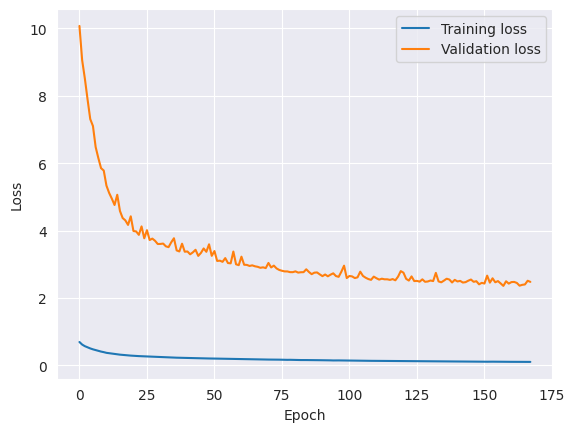

In [56]:
torch.manual_seed(190401060)
mlp = MLP()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mlp.to(device)


list_train_loss, list_val_loss = [], []
best_val_loss = None
optimizer = optim.SGD(mlp.parameters(), lr=0.001)
patience = 10

patience_counter = 0
num_epochs =200
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0

    mlp.train()
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_batch = y_batch.view(-1, 1)
        optimizer.zero_grad()
        outputs = mlp(X_batch)
        loss = mlp.loss(outputs, y_batch)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)

    mlp.eval()
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_batch = y_batch.view(-1, 1)
            outputs = mlp(X_batch)
            loss = mlp.loss(outputs, y_batch)
          
            val_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_dataset)
    val_loss /= len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch}, Training loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}')

    list_train_loss.append(train_loss)
    list_val_loss.append(val_loss)

    val_score = val_loss
    if best_val_loss is None:
        best_val_loss = val_score 
        torch.save(mlp.state_dict(), "checkpoint.pt")
    elif best_val_loss < val_score: 
        patience_counter += 1
        print("Earlystopping Patience Counter:",patience_counter)
        if patience_counter == patience:
            break
    else:
        best_val_loss = val_score
        torch.save(mlp.state_dict(), "checkpoint.pt") 
        patience_counter = 0

sns.set_style("darkgrid")
plt.plot(list_train_loss, label="Training loss")
plt.plot(list_val_loss, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
    


In [57]:
#!pip install torcheval
#!pip install torchmetrics
from torcheval.metrics.functional import binary_f1_score
from torcheval.metrics.functional import binary_accuracy
from torchmetrics import Precision, Recall

model = MLP()
model.load_state_dict(torch.load('checkpoint.pt'))

predictions = []
ground_truths = []

model.eval()
with torch.no_grad():
    for inputs,labels in test_loader:
        outputs = model(inputs)
        predicted = torch.round(outputs)
        predictions.extend(predicted.tolist())
        ground_truths.extend(labels.tolist())

ground_truths = torch.tensor(ground_truths).to(torch.int64)
predictions = torch.tensor(predictions).to(torch.int64).squeeze(1)


f1_score = binary_f1_score(predictions,ground_truths)

accuracy = binary_accuracy(predictions,ground_truths)

precision = Precision(num_classes=2, average='macro', task='binary')
recall = Recall(num_classes=2, average='macro', task='binary')

precision.update(predictions, ground_truths)
recall.update(predictions, ground_truths)

precision_value = precision.compute()
recall_value = recall.compute()

print(f'Precision: {precision_value:.4f}')
print(f'Recall: {recall_value:.4f}')

print("F1-Score: {:.4f}\nAccuracy: {:.4f}".format(f1_score,accuracy))

Precision: 0.9526
Recall: 0.9330
F1-Score: 0.9427
Accuracy: 0.9430
